#**PCA For Dimensionality Reduction On Tabular Data**

**Intuition:** This is an easy synthetic test: two well-separated clusters in 3D. Because the covariance is identity, the natural principal axes initially align with the coordinate axes — but after you standardize and shuffle things, PCA will reveal directions of greatest overall variance (which in a mixture depends on cluster separation as well as within-cluster spread).

**Generating two classes multivariate normal samples:**

In [2]:
import numpy as np
import pandas as pd

np.random.seed(23)

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)

df = pd.DataFrame(class1_sample,columns=['feature1','feature2','feature3'])
df['target'] = 1

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df1 = pd.DataFrame(class2_sample,columns=['feature1','feature2','feature3'])

df1['target'] = 0

df = pd.concat([df, df1], ignore_index=True)

df = df.sample(40)

In [3]:
df.head()


,feature1,feature2,feature3,target
2,-0.367548,-1.137460,-1.322148,1
34,0.177061,-0.598109,1.226512,0
14,0.420623,0.411620,-0.071324,1
11,1.968435,-0.547788,-0.679418,1
12,-2.506230,0.146960,0.606195,1


**3D scatter with Plotly:**

**Intuition:**
Before applying transformations, see where variance and cluster structure live. PCA’s goal is to find projections that best preserve that structure.

In [5]:
import plotly.express as px

fig = px.scatter_3d(df, x=df['feature1'], y=df['feature2'], z=df['feature3'],
              color=df['target'].astype('str'))
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

**Standard scaling:**

Centers each feature to **mean 0 and scales to unit variance** (z-score).

** PCA:**

PCA depends on variance. If features are on different scales, a feature with large numeric range will dominate principal components even if it’s not more informative.

Centering (subtracting mean) ensures the covariance matrix captures variance around the data center  PCA is defined on centered data.

Unit variance scaling gives each feature equal a priori importance when scales differ.


In [6]:



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df.iloc[:,0:3] = scaler.fit_transform(df.iloc[:,0:3])

**Covariance matrix:**

Cov(Xi​,Xj​)=N−11​t∑​(Xti​−Xˉi​)(Xtj​−Xˉj​)

Diagonal elements = variances of each feature.

Off-diagonals = how two features co-vary. Positive covariance → they move together; negative → move opposite.

 PCA finds orthogonal directions that diagonalize this covariance matrix — i.e., find directions with no cross-covariance and ordered variances.

In [7]:


covariance_matrix = np.cov([df.iloc[:,0],df.iloc[:,1],df.iloc[:,2]])
print('Covariance Matrix:\n', covariance_matrix)

Covariance Matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]


**Eigen decomposition**

**intuition:**

Eigenvectors = principal axes (directions in original feature space).

Eigenvalues = variance along those axes. A larger eigenvalue → that direction captures more of the data variance.

Because the covariance matrix is symmetric, eigenvectors are orthogonal (perpendicular) — nice geometric basis.

The first eigenvector corresponds to direction with largest spread of the (standardized) data.

In [8]:

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [9]:
eigen_values

array([1.3536065 , 0.94557084, 0.77774573])

In [10]:

eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

**Plotting eigenvectors in 3D (Arrow3D):**

Populating the interactive namespace from numpy and matplotlib


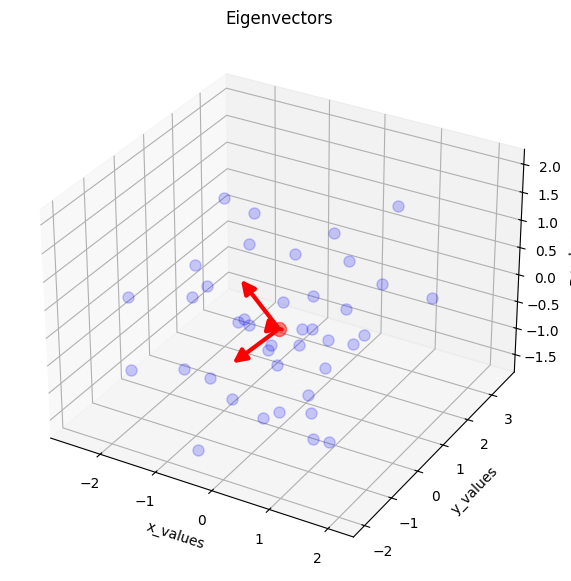

In [16]:
%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M) # Changed renderer.M to self.axes.M
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        x0, y0, z0 = proj3d.proj_transform(xs3d[0], ys3d[0], zs3d[0], self.axes.M) # Changed renderer.M to self.axes.M
        x1, y1, z1 = proj3d.proj_transform(xs3d[1], ys3d[1], zs3d[1], self.axes.M) # Changed renderer.M to self.axes.M
        return max(int(z0), int(z1))


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(df['feature1'], df['feature2'], df['feature3'], 'o', markersize=8, color='blue', alpha=0.2)
ax.plot([df['feature1'].mean()], [df['feature2'].mean()], [df['feature3'].mean()], 'o', markersize=10, color='red', alpha=0.5)
for v in eigen_vectors.T:
    a = Arrow3D([df['feature1'].mean(), v[0]], [df['feature2'].mean(), v[1]], [df['feature3'].mean(), v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

**Selecting principal components and projecting:**

In [17]:
pc = eigen_vectors[0:2]
pc

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442]])

In [18]:
transformed_df = np.dot(df.iloc[:,0:3],pc.T)

new_df = pd.DataFrame(transformed_df,columns=['PC1','PC2'])
new_df['target'] = df['target'].values
new_df.head()

,PC1,PC2,target
0,0.599433,1.795862,1
1,1.056919,-0.212737,0
2,-0.271876,0.498222,1
3,-0.621586,0.023110,1
4,1.567286,1.730967,1


**Creating new_df and plotting PCs**

In [19]:
fig = px.scatter(x=new_df['PC1'],
                 y=new_df['PC2'],
                 color=new_df['target'],
                 color_discrete_sequence=px.colors.qualitative.G10
                )

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()


#**PCA for Dimensionality Reduction in Multivariate Time Series Data**

PCA looks for correlations among variables (columns) not directly across time to find fewer latent signals explaining most variability.

**Small Synthetic MV Time Series:**

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

time = np.arange(0, 100, 1)

latent = np.sin(0.1 * time) + 0.1 * np.random.randn(len(time))

sensor_1 = latent + 0.05 * np.random.randn(len(time))
sensor_2 = 0.8 * latent + 0.05 * np.random.randn(len(time))
sensor_3 = -0.5 * latent + 0.05 * np.random.randn(len(time))  # negatively correlated
sensor_4 = np.random.randn(len(time))  # independent noise

df = pd.DataFrame({
    'time': time,
    'sensor_1': sensor_1,
    'sensor_2': sensor_2,
    'sensor_3': sensor_3,
    'sensor_4': sensor_4
})

df.set_index('time', inplace=True)
df.head()


,sensor_1,sensor_2,sensor_3,sensor_4
time,,,,
0,-0.021097,0.057627,-0.066285,-1.594428
1,0.064975,0.096845,-0.071013,-0.599375
2,0.246302,0.264903,-0.094354,0.005244
3,0.407709,0.410949,-0.193393,0.046981
4,0.357939,0.223919,-0.184047,-0.450065


**Visualize the Raw Multivariate Time Series**

**Sensor 1**

Follows a smooth sinusoidal wave with slight noise.

Very close to the “latent” signal.

This is your high-quality sensor — the baseline.

**Sensor 2**

Same periodic wave, smaller amplitude.

Still strongly correlated with sensor 1.

Represents a sensor that’s reading the same process but scaled down.

**Sensor 3**

Inverted (mirror image) version of sensor 1.

Same frequency, opposite direction → clear negative correlation.

**Sensor 4**

Random jitter, no visible pattern.

Doesn’t track others — pure noise (uncorrelated).

1) The first three plots show synchronized sensors — normal operation.

2) The last one is noise — maybe a broken sensor.

3) Any deviation of one sensor’s wave from others → anomaly or drift.

1) The first principal component (PC1) will capture the shared wave pattern of sensors 1–3.

2) The fourth sensor will appear mostly in later components (low variance).

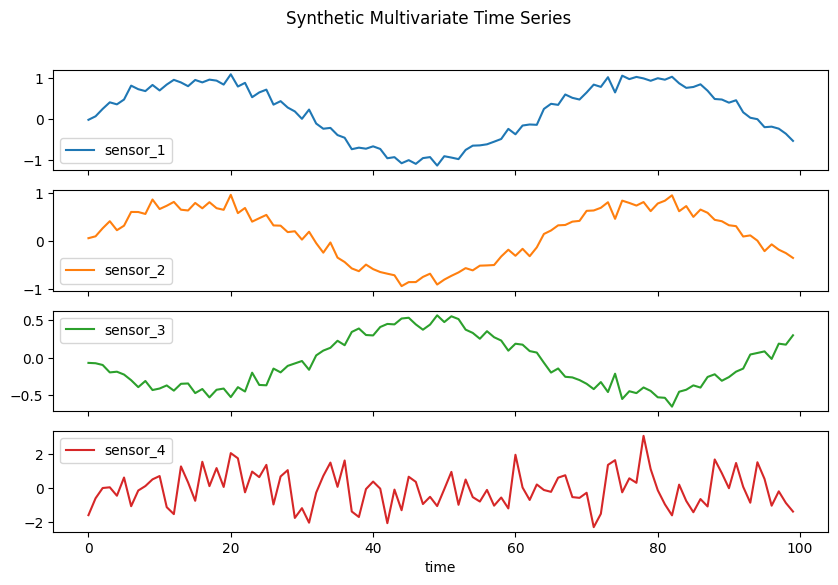

In [21]:
df.plot(subplots=True, figsize=(10,6), title='Synthetic Multivariate Time Series')
plt.show()


**Apply PCA for Dimensionality Reduction**

PCA identifies directions of maximum variance.
If one sensor has large numerical values

1) To reduce data dimensionality while retaining most of the variability.

2) To remove correlation between sensor variables in multivariate time series.

3) To identify latent structures (underlying factors) that drive system behavior.

4) To prepare the data for more stable modeling and anomaly detection.

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


scaler = StandardScaler()
scaled = scaler.fit_transform(df)


pca = PCA(n_components=4)
pca_features = pca.fit_transform(scaled)

pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(4)], index=df.index)
pca_df.head()


,PC1,PC2,PC3,PC4
time,,,,
0,-0.523315,-1.391194,-0.088736,-0.098846
1,-0.248219,-0.481842,-0.047561,-0.063196
2,0.214905,0.023943,0.123620,-0.052770
3,0.681453,-0.014226,0.094756,-0.084131
4,0.350189,-0.435170,-0.095309,0.067705


**Explained Variance**

1) To determine how many principal components are sufficient to represent most of the variability in the dataset.

2) Helps decide the optimal number of components to retain for dimensionality reduction.

3) In time series analysis, this ensures you preserve the dominant system dynamics while discarding noise-dominated components.

In [23]:
explained = pca.explained_variance_ratio_
print("Explained variance ratio:", explained)
print("Cumulative variance explained:", np.cumsum(explained))


Explained variance ratio: [0.75849587 0.23636781 0.00343386 0.00170245]
Cumulative variance explained: [0.75849587 0.99486369 0.99829755 1.        ]


**Plotting PCA Components Over Time**

1) To visualize how PCA compresses correlated multivariate data into a smaller number of uncorrelated components.

2) To verify that PC1 captures the dominant temporal pattern present across the original sensors.

3) To confirm that dimensionality reduction preserves the underlying time series dynamics while removing redundancy and noise.

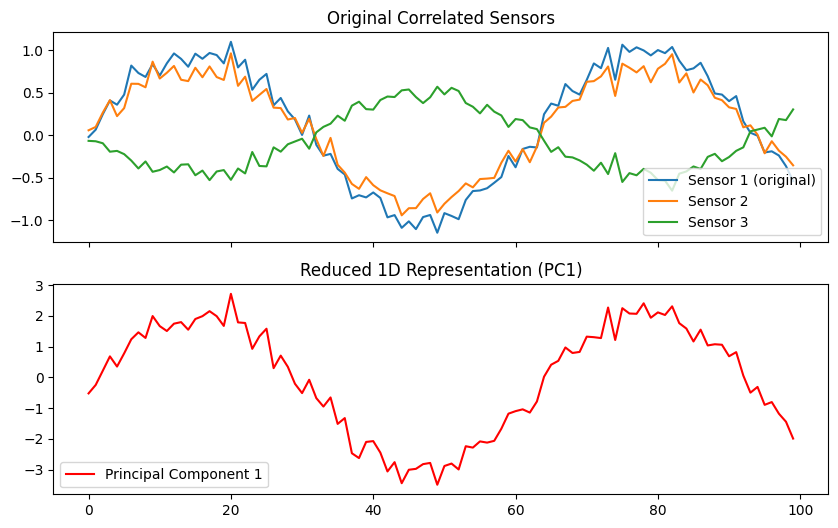

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True)

ax[0].plot(df['sensor_1'], label='Sensor 1 (original)')
ax[0].plot(df['sensor_2'], label='Sensor 2')
ax[0].plot(df['sensor_3'], label='Sensor 3')
ax[0].set_title('Original Correlated Sensors')
ax[0].legend()

ax[1].plot(pca_df['PC1'], label='Principal Component 1', color='red')
ax[1].set_title('Reduced 1D Representation (PC1)')
ax[1].legend()

plt.show()


 **Explanation**

Purpose of this Visualization

To compare the original multivariate time series signals (which are correlated and redundant) with their principal component representation after PCA.

This demonstrates how PCA compresses the information from multiple sensors into a single representative signal (PC1).

**Upper Plot (Original Sensors)**

1) Displays sensor_1, sensor_2, and sensor_3 over time.

2) These signals are highly correlated since they share the same underlying latent trend.

3) Visually, they move in similar patterns, indicating redundant information.

**Lower Plot(Principal Component 1)**

1) Shows the first principal component (PC1), which captures the maximum variance across all sensors.

2) PC1 effectively summarizes the shared trend of all correlated sensors into a single time series.

3) This is the reduced-dimensional representation of the multivariate data.